# Fast TopK elements

Looking for the top k elements is something needed to implement a simple k nearest neighbors. The implementation *scikit-learn* is using relies on *numpy*: [_kneighbors_reduce_func](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/_base.py#L496). *mlprodict* also contains a C++ implementation of the same function. Let's compare them.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Two implementations

We assume we are looking for the `k` nearest elements of every row of matrix `X` which is a dense matrix of doubles.

In [3]:
import numpy.random as rnd
from sklearn.neighbors._base import KNeighborsMixin

mixin = KNeighborsMixin()

In [4]:
def topk_sklearn(X, k):
    return mixin._kneighbors_reduce_func(X, 0, k, False)
    
X = rnd.randn(5, 10)
ind = topk_sklearn(X, 3)
ind

array([[2, 7, 3],
       [7, 0, 8],
       [1, 5, 6],
       [8, 9, 3],
       [4, 6, 5]], dtype=int64)

Now the implementation with *mlprodict* (C++) available at [topk_element_min](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/_op_onnx_numpy.cpp#L201). It uses [heap](https://en.wikipedia.org/wiki/Heap_(data_structure)).

In [5]:
from mlprodict.onnxrt.ops_cpu._op_onnx_numpy import topk_element_min_double

In [6]:
def topk_cpp(X, k):
    return topk_element_min_double(X, k, True, 50)
    
ind = topk_cpp(X, 3)
ind

array([[2, 7, 3],
       [7, 0, 8],
       [1, 5, 6],
       [8, 9, 3],
       [4, 6, 5]], dtype=int64)

## Speed comparison by size

In [7]:
%timeit topk_sklearn(X, 3)

21.7 µs ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%timeit topk_cpp(X, 3)

4.1 µs ± 435 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Quite a lot faster on this simple example. Let's look for bigger matrices.

In [9]:
X = rnd.randn(1000, 100)

In [10]:
%timeit topk_sklearn(X, 10)

1.8 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit topk_cpp(X, 10)

786 µs ± 116 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
from cpyquickhelper.numbers import measure_time
from tqdm import tqdm
from pandas import DataFrame

rows = []
for n in tqdm(range(1000, 10001, 1000)):
    X = rnd.randn(n, 1000)
    res = measure_time('topk_sklearn(X, 20)',
                       {'X': X, 'topk_sklearn': topk_sklearn},
                       div_by_number=True,
                       number=2, repeat=2)
    res["N"] = n
    res["name"] = 'topk_sklearn'
    rows.append(res)
    res = measure_time('topk_cpp(X, 20)',
                       {'X': X, 'topk_cpp': topk_cpp},
                       div_by_number=True,
                       number=4, repeat=4)
    res["N"] = n
    res["name"] = 'topk_cpp'
    rows.append(res)

df = DataFrame(rows)
df.head()

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,N,name
0,0.016310,0.000260,0.016050,0.016571,2,2,240,1000,topk_sklearn
1,0.003872,0.000501,0.003335,0.004631,4,4,240,1000,topk_cpp
2,0.034684,0.001629,0.033055,0.036313,2,2,240,2000,topk_sklearn
3,0.006973,0.000558,0.006307,0.007756,4,4,240,2000,topk_cpp
4,0.051934,0.000851,0.051084,0.052785,2,2,240,3000,topk_sklearn


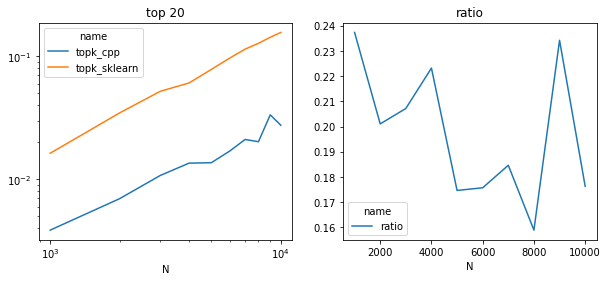

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv = df.pivot("N", "name", "average")
piv.plot(ax=ax[0], logy=True, logx=True)
ax[0].set_title("top 20")
piv["ratio"] = piv["topk_cpp"] / piv["topk_sklearn"]
piv[["ratio"]].plot(ax=ax[1])
ax[1].set_title("ratio");

## Speed comparison by k

In [14]:
rows = []
X = rnd.randn(2000, 1000)
for k in tqdm(list(range(1, 20)) + list(range(20, 1000, 20))):
    res = measure_time('topk_sklearn(X, k)',
                       {'X': X, 'topk_sklearn': topk_sklearn, 'k': k},
                       div_by_number=True,
                       number=2, repeat=2)
    res["k"] = k
    res["name"] = 'topk_sklearn'
    rows.append(res)
    res = measure_time('topk_cpp(X, k)',
                       {'X': X, 'topk_cpp': topk_cpp, 'k': k},
                       div_by_number=True,
                       number=2, repeat=2)
    res["k"] = k
    res["name"] = 'topk_cpp'
    rows.append(res)

df = DataFrame(rows)
df.head()

100%|██████████| 68/68 [00:34<00:00,  1.95it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,k,name
0,0.009558,0.001392,0.008166,0.010949,2,2,240,1,topk_sklearn
1,0.002665,0.000571,0.002094,0.003236,2,2,240,1,topk_cpp
2,0.021933,0.000575,0.021358,0.022508,2,2,240,2,topk_sklearn
3,0.001000,0.000084,0.000917,0.001084,2,2,240,2,topk_cpp
4,0.025986,0.001411,0.024575,0.027398,2,2,240,3,topk_sklearn


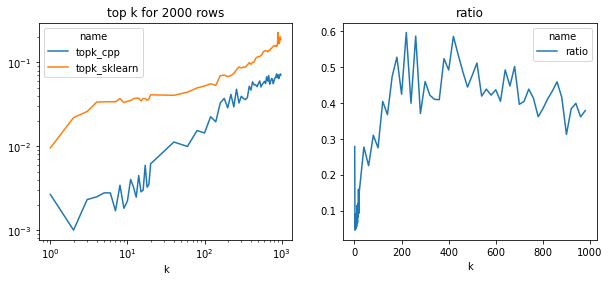

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
piv = df.pivot("k", "name", "average")
piv.plot(ax=ax[0], logy=True, logx=True)
ax[0].set_title("top k for 2000 rows")
piv["ratio"] = piv["topk_cpp"] / piv["topk_sklearn"]
piv[["ratio"]].plot(ax=ax[1])
ax[1].set_title("ratio")
ax[0].set_xlabel("k")
ax[1].set_xlabel("k");

The implementation is half faster in all cases and much more efficient for small values which is usually the case for the nearest neighbors. This implementation is using *openmp*, maybe that's why it gets 50% faster on this two cores machine.